## Fun with Neural Networks Part 1.

Currently, the majority of work with neural networks has been in the regression/classification steps. For instance, people think about trying to predict a given output value, given a set of inputs. However, given the way that neural networks work, I think they can be easily extended to also find optimal solutions for unknown functions.

A few of the applications that I've been thinking about

1. Imagine we have a dataset in which patients are given a variety of different medication. We have measured the following, their genetic status, the drugs that they have been administered, and some outcome measure. For each patient, can we find an optimial combination of drugs to best handle their disease.

2. Certain features are important in terms of predicting things like solubility or target engagement, can we propose a new structure that will optimize solubility and/or binding.

So the overall thought is to use neural networks to do the basic prediction task, but then understand that the neural network gives a differentiable function that we can then use to find at least a local minima. 

One of the nicer things is that because neural networks already work via gradient descent, we can easily use the same NN solvers to find the optimal solutions

In [1]:
import warnings
import os

warnings.filterwarnings('ignore')

from json import load
import pandas as pd
import numpy as np
import keras.backend as K
import tensorflow as tf
import math

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Layer, Lambda
from tensorflow.keras.models import Model, load_model

import matplotlib.pyplot as plt

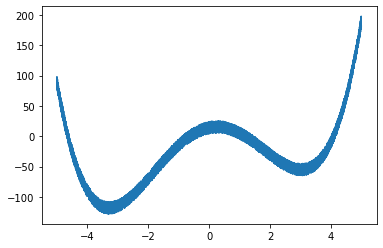

In [2]:
# This is just intended to generate some data for which the minima can be easily seen visually.
# It's a bit of a toy problem, but I think it's sufficient to illustrate the point. 
x = np.arange(0, 10000)/1000.0 - 5
y = x ** 4 - 20 * x ** 2 +  10 * x + 4 + np.random.rand(len(x)) * 20
plt.plot(x, y)

In [3]:
# reshape the matrix so it's compatible with keras
x = x.reshape(len(x), 1)

In [4]:
import ipywidgets

#this is our basic model that we're going to use to reconstruct the function

input_layer = Input(shape=(1,))
hidden_layer = Dense(12, activation='elu')(input_layer)
hidden_layer = Dense(9, activation='elu')(hidden_layer)
hidden_layer = Dense(6, activation='elu')(hidden_layer)
hidden_layer = Dense(3, activation='elu')(hidden_layer)
decoder = Dense(1, activation='linear')(hidden_layer)

model = Model(input_layer, decoder)
model.compile(loss='mse', optimizer='rmsprop')
model.fit(x, y, batch_size=16, epochs=20, validation_data=(x,y), verbose = 1)

Metal device set to: Apple M1 Pro
Epoch 1/20


2021-11-27 13:24:54.674679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-27 13:24:54.674802: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-11-27 13:24:54.749148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-27 13:24:54.749349: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


  6/625 [..............................] - ETA: 6s - loss: 3672.1875  

2021-11-27 13:24:54.920973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


623/625 [============================>.] - ETA: 0s - loss: 3232.3240

2021-11-27 13:25:00.675850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 8s 13ms/step - loss: 3228.3354 - val_loss: 2400.8242
Epoch 2/20
625/625 [==============================] - 8s 12ms/step - loss: 2313.9438 - val_loss: 2229.4878
Epoch 3/20
625/625 [==============================] - 8s 12ms/step - loss: 2141.9741 - val_loss: 2054.8533
Epoch 4/20
625/625 [==============================] - 8s 13ms/step - loss: 1968.2542 - val_loss: 1872.4642
Epoch 5/20
625/625 [==============================] - 8s 13ms/step - loss: 1733.7938 - val_loss: 1547.9813
Epoch 6/20
625/625 [==============================] - 8s 13ms/step - loss: 1292.1952 - val_loss: 1030.3175
Epoch 7/20
625/625 [==============================] - 8s 12ms/step - loss: 756.0240 - val_loss: 454.7518
Epoch 8/20
625/625 [==============================] - 8s 13ms/step - loss: 307.8468 - val_loss: 197.5898
Epoch 9/20
625/625 [==============================] - 8s 13ms/step - loss: 143.6030 - val_loss: 113.3809
Epoch 10/20
625/625 [==============================] -

In [5]:
model.fit(x, y, batch_size=4, epochs=20, validation_data=(x,y), verbose = 1)

Epoch 1/20
   7/2500 [..............................] - ETA: 23s - loss: 36.6902

2021-11-27 13:27:31.970822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2496/2500 [============================>.] - ETA: 0s - loss: 44.8901

2021-11-27 13:27:54.496494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 32s 13ms/step - loss: 44.9129 - val_loss: 44.3644
Epoch 2/20
2500/2500 [==============================] - 32s 13ms/step - loss: 44.1604 - val_loss: 41.5571
Epoch 3/20
2500/2500 [==============================] - 32s 13ms/step - loss: 44.0206 - val_loss: 51.2217
Epoch 4/20
2500/2500 [==============================] - 32s 13ms/step - loss: 44.0979 - val_loss: 39.1589
Epoch 5/20
2500/2500 [==============================] - 768s 307ms/step - loss: 43.8481 - val_loss: 44.1209
Epoch 6/20
2500/2500 [==============================] - 976s 391ms/step - loss: 43.2917 - val_loss: 46.8179
Epoch 7/20
2500/2500 [==============================] - 32s 13ms/step - loss: 43.4532 - val_loss: 38.4760
Epoch 8/20
2500/2500 [==============================] - 33s 13ms/step - loss: 43.4825 - val_loss: 36.2865
Epoch 9/20
2500/2500 [==============================] - 33s 13ms/step - loss: 43.4577 - val_loss: 45.4941
Epoch 10/20
2500/2500 [==============================

In [6]:
# predict the curve again. Yes this is a self prediction, but we'll leave the cross validation as 
# an exercise for the reader
p = model.predict(x)

2021-11-27 14:07:09.094966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


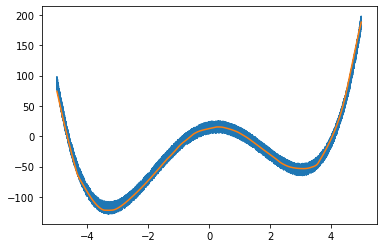

In [7]:
# unsurprisingly it is able to replicate the original function
plt.plot(x, y)
plt.plot(x, p)

In [8]:
# we're going to freeze the model
model.trainable = False

### Optimization

The previous section was a pretty straightforward data generation and training of the neural network. Within the next section we're going to be trying to find the optimal solution.

Essentailly, we want to have a "layer" whose weights can be optimized, and which serve as an input to the trained model. 

In [9]:
# I don't really care about the input and output at this point 
sample_input = np.ones(10000).reshape(10000, 1)
#this doesn't matter at all, we're just going to minimize the function
sample_output = np.zeros(10000)

In [10]:
# this loss function is just the value of the function we're trying to minimize.
# all of the inputs are the same and so we don't really care about y_true
def my_loss_fn(y_true, y_pred):
    return tf.reduce_mean(y_pred, axis=-1) 

In [11]:
class custom_layer(Layer):
    def  __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(custom_layer,self).__init__(**kwargs)
    def build(self,input_shape):
        output_shape = self.compute_output_shape(input_shape)
        self.W=self.add_weight(name='kernel',
                           shape=(1,) + output_shape[1:],
                           initializer='uniform'                              ,
                           trainable=True)
        self.built = True
  # this self.built is necessary .
    def call(self,x):
        return x * self.W
    def compute_output_shape(self, input_shape):
        return(input_shape)

In [12]:
# input layer
new_input_layer =  Input(shape=(1,))
l = custom_layer(1)
# this is the layer whose weight we believe is going to be the minimum
new_weight_layer = l(new_input_layer)
# the model that we trained previously
transfer = model(new_weight_layer, training=False)

optimization_model = Model(new_input_layer, transfer)
optimization_model.compile('rmsprop', loss = my_loss_fn)
optimization_model.summary()
# basic training framework that is used in keras
optimization_model.fit(sample_input, sample_output, batch_size=4, epochs=5, validation_data=(x,y), verbose = 1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
custom_layer (custom_layer)  (None, 1)                 1         
_________________________________________________________________
model (Functional)           (None, 1)                 226       
Total params: 227
Trainable params: 1
Non-trainable params: 226
_________________________________________________________________
Epoch 1/5
  24/2500 [..............................] - ETA: 16s - loss: 12.1414

2021-11-27 14:07:10.475298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2497/2500 [============================>.] - ETA: 0s - loss: -36.2829

2021-11-27 14:07:26.749144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2500/2500 [==============================] - 25s 10ms/step - loss: -36.3596 - val_loss: 494.9738
Epoch 2/5
2500/2500 [==============================] - 25s 10ms/step - loss: -119.8081 - val_loss: 817.4183
Epoch 3/5
2500/2500 [==============================] - 25s 10ms/step - loss: -122.1774 - val_loss: 817.4178
Epoch 4/5
2500/2500 [==============================] - 25s 10ms/step - loss: -122.1774 - val_loss: 817.4185
Epoch 5/5
2500/2500 [==============================] - 25s 10ms/step - loss: -122.1774 - val_loss: 817.4178


In [13]:
optimum_x = l.get_weights()[0][0][0]
print(optimum_x)
optimum_y = model.predict(np.array([optimum_x]))

-3.3199105


2021-11-27 14:09:15.855995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


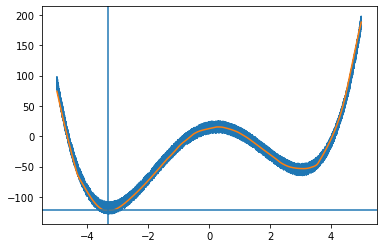

In [14]:
plt.plot(x, y)
plt.plot(x, p)

plt.axvline(x=optimum_x)
plt.axhline(y=optimum_y)